In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
np.set_printoptions(precision=3, suppress=True)

In [135]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [136]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Load data

In [137]:
raw_dataset = pd.read_excel("../Data/Real estate valuation data set.xlsx")

In [138]:
raw_dataset

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...
409,2013.000000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,2012.666667,5.6,90.45606,9,24.97433,121.54310,50.0
411,2013.250000,18.8,390.96960,7,24.97923,121.53986,40.6
412,2013.000000,8.1,104.81010,5,24.96674,121.54067,52.5


In [139]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            414 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


__Data dict__
 - X1 transaction date: The   transaction date (for example, 2013.250=2013 March (3/12=0.25 -> March), 2013.500=2013 June, etc.)
 - X2 house age: The house age   (unit: year)
 - X3 distance to the nearest MRT station: The distance   to the nearest MRT station (unit: meter)
 - X4 number of convenience stores: The number of   convenience stores in the living circle on foot
 - X5 latitude: The geographic   coordinate, latitude (unit: degree)
 - X6 longtitude: The geographic   coordinate, longitude (unit: degree)
 - Y house price of unit area: The house price of unit   area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3   meter squared) for example, 29.3 = 293,000 New Taiwan Dollar/Ping

In [140]:
dataset = raw_dataset.copy()

## Preprocessing

### Rename columns

In [141]:
dataset = dataset.rename(columns={
                'X1 transaction date': 'X1',
                'X2 house age': 'X2',
                'X3 distance to the nearest MRT station': 'X3',
                'X4 number of convenience stores': 'X4',
                'X5 latitude': 'X5',
                'X6 longitude': 'X6',
                'Y house price of unit area': 'Y'
            })

### Transform datetime

In [142]:
# Set type as string for manipulate data
dataset['X1'] = dataset['X1'].astype(str)

In [143]:
# Split year and month
tmp = dataset['X1'].str.split('.', expand=True)

# Transform to month
tmp[1] = ('0.' + tmp[1]).astype(float)
tmp[1] = np.ceil(tmp[1]*12)

In [144]:
# Assign the values
dataset['year'] = tmp[0].astype(int)
dataset['month'] = tmp[1].astype(int)

In [145]:
dataset.drop(columns='X1', inplace=True)

## EDA

### Show shape of the data

In [146]:
dataset.shape

(414, 8)

### Count the non-missing value

In [147]:
dataset.count()

X2       414
X3       414
X4       414
X5       414
X6       414
Y        414
year     414
month    414
dtype: int64

### Describe statistic

In [148]:
dataset.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
X2,414.0,17.712560,11.392485,0.00000,9.025000,16.10000,28.150000,43.80000
X3,414.0,1083.885689,1262.109595,23.38284,289.324800,492.23130,1454.279000,6488.02100
X4,414.0,4.094203,2.945562,0.00000,1.000000,4.00000,6.000000,10.00000
X5,414.0,24.969030,0.012410,24.93207,24.963000,24.97110,24.977455,25.01459
X6,414.0,121.533361,0.015347,121.47353,121.528085,121.53863,121.543305,121.56627
Y,414.0,37.980193,13.606488,7.60000,27.700000,38.45000,46.600000,117.50000
year,414.0,2012.695652,0.460687,2012.00000,2012.000000,2013.00000,2013.000000,2013.00000
month,414.0,5.804348,3.538495,0.00000,3.000000,6.00000,9.000000,12.00000


### Numeric distribution

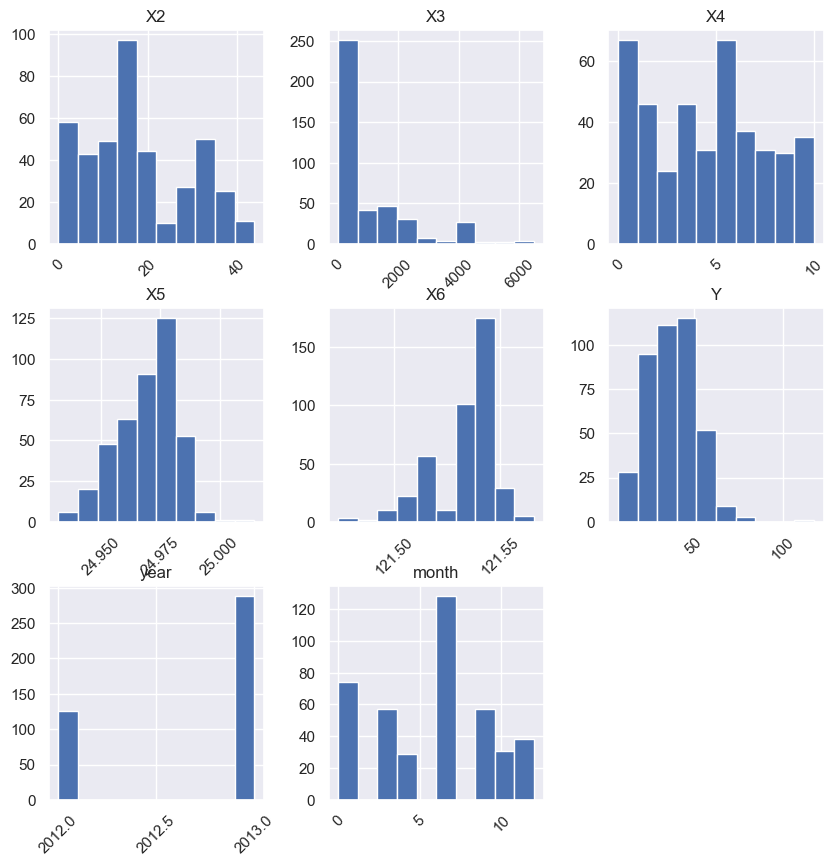

In [149]:
dataset.hist(figsize=(10,10), xrot=45)
plt.show()

### Check correlation

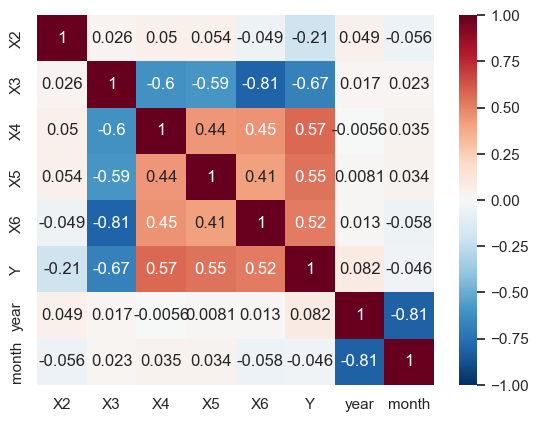

In [150]:
corr = dataset.corr(numeric_only=True)

sns.heatmap(corr, cmap='RdBu_r', annot=True, vmax=1, vmin=-1)
plt.show()

### Variance Inflation Factor

In [151]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = dataset.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(dataset.values, i)
                          for i in range(len(dataset.columns))]
  
print(vif_data)

  feature           VIF
0      X2  3.916505e+00
1      X3  5.442664e+00
2      X4  5.215634e+00
3      X5  6.661457e+06
4      X6  4.550037e+07
5       Y  2.090391e+01
6    year  4.616676e+07
7   month  9.506263e+00


Features with a VIF value higher than 5 should be removed. But in the future, we'll utilize latitude and longitude data, or X5 and X6 data, for clustering.

## Feature engineering

### Clustering house by location

#### Plot data

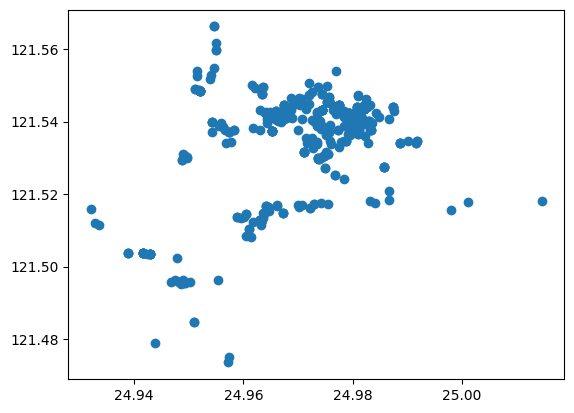

In [86]:
plt.scatter(dataset['X5'], dataset['X6'])
plt.show()

In [87]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

for n_components in range(3, 7):
    gmm = GaussianMixture(n_components=n_components).fit(dataset[['X5', 'X6']])
    labels = gmm.predict(dataset[['X5', 'X6']])
    score = silhouette_score(dataset[['X5', 'X6']], labels)
    print("For n_clusters = {}, silhouette score is {})".format(n_components, score))
    
    
# plt.scatter(dataset['X5'], dataset['X6'], c=labels, s=40, cmap='viridis');

For n_clusters = 3, silhouette score is 0.5219874415014945)
For n_clusters = 4, silhouette score is 0.503284567230058)
For n_clusters = 5, silhouette score is 0.2955424146585263)
For n_clusters = 6, silhouette score is 0.45767195705577624)


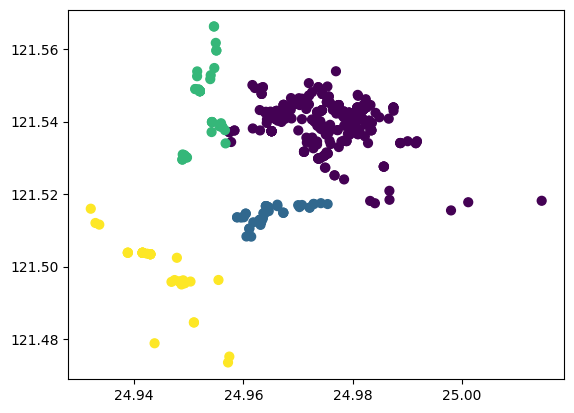

In [88]:
gmm = GaussianMixture(n_components=4).fit(dataset[['X5', 'X6']])
labels = gmm.predict(dataset[['X5', 'X6']])
plt.scatter(dataset['X5'], dataset['X6'], c=labels, s=40, cmap='viridis');

In [89]:
dataset['cluster'] = labels

In [90]:
dataset

,X1,X2,X3,X4,X5,X6,Y,year,month,cluster
0,2012.9166667,32.0,84.87882,10,24.98298,121.54024,37.9,2012,11,0
1,2012.9166667,19.5,306.59470,9,24.98034,121.53951,42.2,2012,11,0
2,2013.5833333,13.3,561.98450,5,24.98746,121.54391,47.3,2013,6,0
3,2013.5,13.3,561.98450,5,24.98746,121.54391,54.8,2013,6,0
4,2012.8333333,5.0,390.56840,5,24.97937,121.54245,43.1,2012,9,0
...,...,...,...,...,...,...,...,...,...,...
409,2013.0,13.7,4082.01500,0,24.94155,121.50381,15.4,2013,0,3
410,2012.6666667,5.6,90.45606,9,24.97433,121.54310,50.0,2012,8,0
411,2013.25,18.8,390.96960,7,24.97923,121.53986,40.6,2013,3,0
412,2013.0,8.1,104.81010,5,24.96674,121.54067,52.5,2013,0,0
